# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from bert import *

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
path = Path('data/composers/notewise/piano_solo/note_range62/sample_freq12')

In [4]:
# bs=16
# bptt=250

In [5]:
bs=2
bptt=5

In [6]:
data = TextLMDataBunch.load(path, bs=bs, bptt=bptt)

In [7]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

158

In [8]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos wait25 wait25 wait25 wait25 wait25 wait25 wa',
 array([  2, 124, 124, 124, ...,   9, 105,   9, 157]))

In [9]:
# data.show_batch()

## Sanity - make sure outputs match

In [7]:
# learn = language_model_learner(data, drop_mult=1, clip=.5, bptt=250)

# ob = data.one_batch()

# out = learn.model(ob[0].cuda())

# out[0].shape

# len(out[1])

### Transformer Arch
Paper: https://arxiv.org/abs/1706.03762  
Inspiration: https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [10]:

class BertLMPredictionHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertLMPredictionHead, self).__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(bert_model_embedding_weights.size(1),
                                 bert_model_embedding_weights.size(0),
                                 bias=False)
        self.decoder.weight = bert_model_embedding_weights
        self.bias = nn.Parameter(torch.zeros(bert_model_embedding_weights.size(0)))

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states) + self.bias
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertOnlyMLMHead, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores
    

class BertPreTrainingHeads(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertPreTrainingHeads, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output)
        seq_relationship_score = self.seq_relationship(pooled_output)
        return prediction_scores, seq_relationship_score


class PreTrainedBertModel(nn.Module):
    """ An abstract class to handle weights initialization and
        a simple interface for dowloading and loading pretrained models.
    """
    def __init__(self, config, *inputs, **kwargs):
        super(PreTrainedBertModel, self).__init__()
        if not isinstance(config, BertConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
                "To create a model from a Google pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        self.config = config

    def init_bert_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.normal_(mean=0.0, std=self.config.initializer_range)
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()



class BertModel(PreTrainedBertModel):
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, token_type_ids)
        encoded_layers = self.encoder(embedding_output,
                                      extended_attention_mask,
                                      output_all_encoded_layers=output_all_encoded_layers)
        sequence_output = encoded_layers[-1]
        pooled_output = self.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return encoded_layers, pooled_output


class BertForPreTraining(PreTrainedBertModel):
    def __init__(self, config):
        super(BertForPreTraining, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                                   output_all_encoded_layers=False)
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output)

        if masked_lm_labels is not None and next_sentence_label is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
            next_sentence_loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
            total_loss = masked_lm_loss + next_sentence_loss
            return total_loss
        else:
            return prediction_scores
#             return prediction_scores, seq_relationship_score

class BertForUnidirectionalMaskedLM(PreTrainedBertModel):
    def __init__(self, config):
        super(BertForMaskedLM, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertOnlyMLMHead(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask,
                                       output_all_encoded_layers=False)
        prediction_scores = self.cls(sequence_output)

        if masked_lm_labels is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
            return masked_lm_loss
        else:
            return prediction_scores


class BertForMaskedLM(PreTrainedBertModel):
    def __init__(self, config):
        super(BertForMaskedLM, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertOnlyMLMHead(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask,
                                       output_all_encoded_layers=False)
        prediction_scores = self.cls(sequence_output)

        if masked_lm_labels is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
            return masked_lm_loss
        else:
            return prediction_scores


In [29]:
# hidden_size = embedding size
# attention_heads = multi-attention heads
config = BertConfig(vocab_size, hidden_size=12, 
                    num_hidden_layers=4, intermediate_size=24, num_attention_heads=6)





In [31]:
model = BertForPreTraining(config).cuda()
model.reset = lambda: None

In [32]:
model.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(158, 12)
    (position_embeddings): Embedding(512, 12)
    (token_type_embeddings): Embedding(2, 12)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=12, out_features=12, bias=True)
            (key): Linear(in_features=12, out_features=12, bias=True)
            (value): Linear(in_features=12, out_features=12, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=12, out_features=12, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=12, out_features=24, bias=True)
        )
        (output

In [33]:
# model

In [34]:
ob = data.one_batch(); ob[0].shape

torch.Size([2, 13])

In [35]:
ob[1].shape

torch.Size([2, 13])

In [36]:
out = model.bert(ob[0].cuda())

In [ ]:

class BertDecoder(nn.Module):
    def __init__(self, config):
        super(BertDecoder, self).__init__()
        layer = BertLayer(config)
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.num_hidden_layers)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers

In [37]:
len(out)

2

In [38]:
len(out[0])

4

In [39]:
out[0][0].shape # batch_size, bptt, embed_size

torch.Size([2, 13, 12])

In [40]:
out[1].shape # batch_size, embed_size

torch.Size([2, 12])

In [46]:
max_length=10
np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)

# Reshape to 4D Tensor to handle multiple heads
# return torch_mask.unsqueeze(0).unsqueeze(1)

In [47]:
torch_mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [42]:
out[0]

[tensor([[[ 3.2806e-02,  7.9190e-03,  1.8894e-02,  1.8988e-02,  3.0615e-03,
           -2.5271e-03,  3.5465e-02,  4.3688e-02,  3.0934e-02,  3.0623e-02,
           -2.8933e-02,  1.0982e-02],
          [ 3.2090e-02,  1.3790e-02,  1.8600e-02,  1.9114e-02,  5.0668e-03,
           -5.5195e-03,  3.4787e-02,  4.8168e-02,  3.0979e-02,  3.3365e-02,
           -3.6103e-02,  1.1477e-02],
          [ 2.9084e-02,  1.3604e-02,  1.8023e-02,  1.3680e-02,  1.3718e-02,
           -9.9367e-04,  3.7833e-02,  3.9668e-02,  3.0174e-02,  4.0612e-02,
           -2.6636e-02,  1.9637e-02],
          [ 3.0140e-02,  1.5994e-02,  1.8480e-02,  1.7107e-02,  5.7300e-03,
           -8.8697e-05,  3.5898e-02,  5.2620e-02,  3.0628e-02,  4.0814e-02,
           -3.8358e-02,  1.8999e-02],
          [ 3.4333e-02,  1.6681e-02,  1.9207e-02,  1.8105e-02,  4.0070e-03,
           -1.4917e-03,  3.3758e-02,  5.3686e-02,  3.0982e-02,  3.2102e-02,
           -3.7432e-02,  1.6759e-02],
          [ 3.5298e-02,  1.5952e-02,  1.9269e-02, 

In [21]:
out[0].shape

AttributeError: 'list' object has no attribute 'shape'

### Create Language learner

In [10]:
learn = LanguageLearner(data, model, bptt)

In [11]:
learn.callbacks = []

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


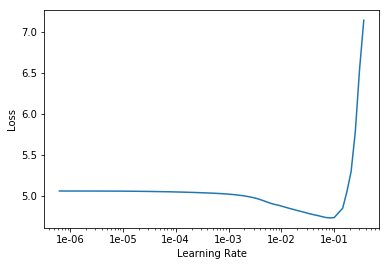

In [13]:
learn.recorder.plot()

## Must remeber that BERT is bidirectional, so we must modifythe architechture so it won't cheat

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy


In [25]:
%debug

> /home/ubuntu/anaconda3/envs/musical_neural_net/lib/python3.7/site-packages/fastai-1.0.40.dev0-py3.7.egg/fastai/callbacks/rnn.py(27)on_loss_begin()
     25     def on_loss_begin(self, last_output:Tuple[Tensor,Tensor,Tensor], **kwargs):
     26         "Save the extra outputs for later and only returns the true output."
---> 27         self.raw_out,self.out = last_output[1],last_output[2]
     28         return last_output[0]
     29 

ipdb> out.shape
*** NameError: name 'out' is not defined
ipdb> up
> /home/ubuntu/anaconda3/envs/musical_neural_net/lib/python3.7/site-packages/fastai-1.0.40.dev0-py3.7.egg/fastai/callback.py(216)on_loss_begin()
    214         self.state_dict['last_output'] = out
    215         for cb in self.callbacks:
--> 216             a = cb.on_loss_begin(**self.state_dict)
    217             if a is not None: self.state_dict['last_output'] = a
    218         return self.state_dict['last_output']

ipdb> up
> /home/ubuntu/anaconda3/envs/musical_neural_net/lib/pyth